***
## Part 3: Machine learning model fitting
***
  - Train test split
  - Model Defintion of candidate models
  - Model Fitting
  - Model Evaluation 
  - Model Tuning
  - Model Revaluation
  - Feature Importance
      - Using Genetic Algorithm
      - Using Tree based feature importance based on Gain criteria
  - Model intuition using Decision tree plotting<br>
  

### 1. Library imports and setting up the environment

In [3]:
import os, sys, pandas as pd, numpy as np
import matplotlib.pyplot as plt
seed=1234
sys.path.append(os.path.abspath('D:\Python WD\codebase'))
from my_utilities import functions
from my_utilities import eda_utilities
import importlib
importlib.reload(functions)
os.getcwd()
os.chdir('D:\Python WD\codebase')

**Functions have been defined in a file named local_functions.py**

### 2. Data load
- data reading
- data type conversion to required format
- rename target variables to represent 1 as positive class(bad loan) and 0 as negative class

In [4]:
###################################################################################
"""data load"""
import joblib
dataset= joblib.load("D:\\Python WD\\codebase\\model_objects\\dataset_feature_engineered")
dataset.head(3)

,patient_id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,...,race,resident_status,date_of_birth,amount,age_at_admission,age_band,bmi,duration_of_stay,count_of_medical_history,bmi_band
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1,0,0,0,0,0,...,Indian,Singaporean,1976-12-19,15405.42,34.0,middle_aged,27.51,10,1,overweight
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0,0,0,0,0,0,...,Malay,Singaporean,1978-07-20,23303.00,32.0,middle_aged,30.62,10,0,obese
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0,0,0,0,0,0,...,Indian,Singaporean,1967-08-14,16813.12,43.0,middle_aged,31.58,11,0,obese


### 3. Extracting list of category and numeric columns

In [5]:
#####################################################################

category_columns= dataset.select_dtypes(['category']).columns.to_list()
numeric_columns= dataset.select_dtypes(['float64','int64']).columns.to_list()
datetime_columns= dataset.select_dtypes(['datetime64[ns]']).columns.to_list()
target= "amount"

### 4. Converting categorical variables to numeric using one-hot encoding <b>
- Extracting list of columns to encode <b>
- Using One hot encoding to perform the encoding <b>

In [6]:
"""category variable encoding"""

dataset_ohe=pd.get_dummies(dataset, columns=category_columns)
print("Checking the datatypes of variables")
print("Category variables have been one hot encoded")
dataset_ohe.dtypes


Checking the datatypes of variables
Category variables have been one hot encoded


patient_id                             object
date_of_admission              datetime64[ns]
date_of_discharge              datetime64[ns]
medical_history_1                       int64
medical_history_2                       int64
medical_history_3                       int64
medical_history_4                       int64
medical_history_5                       int64
medical_history_6                       int64
medical_history_7                       int64
preop_medication_1                      int64
preop_medication_2                      int64
preop_medication_3                      int64
preop_medication_4                      int64
preop_medication_5                      int64
preop_medication_6                      int64
symptom_1                               int64
symptom_2                               int64
symptom_3                               int64
symptom_4                               int64
symptom_5                               int64
lab_result_1                      

### 5. Split data
- Train test data has been split in 80-20% proportion
- Further Model tuning will be done using 5-fold cross validation in the training set
- All the RMSE values will be finally reported on the independent test set

In [9]:
import local_functions
importlib.reload(local_functions)
from sklearn.model_selection import train_test_split
X, test_X,Y, test_Y = train_test_split(dataset_ohe.drop([target], axis= 1), dataset_ohe[[target]], test_size=.2, random_state=seed)


### 6. Define estimators <br>  
1) All model estimators are defined in a list <br>
2) We define two estimators for our experiment: **Decision Tree Regressor** as the Benchmark model and **XGBoost** as a more complex model. The location of model in the list is as follows: <br>  

- 'tree': 1 <br>
- 'xgboost':2 <br>


In [10]:
import local_functions
import importlib
importlib.reload(local_functions)
estimator_list= local_functions.define_estimators()
model_dict= {'Tree': 0, 'XGBoost':1}
print("Models are defined into list called estimator_list. Consecutive elements of the list are different models")

Models are defined into list called estimator_list. Consecutive elements of the list are different models


### 7. Fit models
- Fitting each model to the training set
- Model fit logic is defined in the custom function *fit_estimators()*
- This functions is consuming the list of models and trains all the models and returning the trained models list 

In [11]:
drop_columns= ['patient_id']+datetime_columns
estimator_list= local_functions.fit_estimators(X.drop(columns=drop_columns), Y, estimator_list)


### 8. Evaluate estimators
- We computes the following metric:  
    - RMSE
   

RMSE for the models is as follows:


[4799.643792119936, 2257.1688312343467]

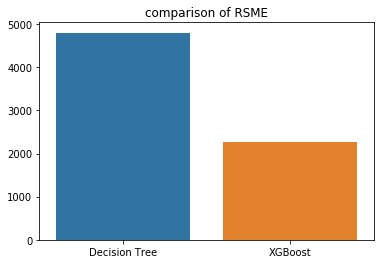

In [12]:
## """evaluate estimators"""
from sklearn.metrics import mean_squared_error
from math import sqrt

Y_PRED_list= [estimator_list[0].predict(test_X.drop(columns=drop_columns)),estimator_list[1].predict(test_X.drop(columns=drop_columns))]
rmse_list = [sqrt(mean_squared_error(test_Y, Y_PRED_list[0])),sqrt(mean_squared_error(test_Y, Y_PRED_list[1]))]
import seaborn as sns
sns.barplot(x=['Decision Tree','XGBoost'],y=rmse_list)
plt.title('comparison of RSME')
print("RMSE for the models is as follows:")
rmse_list

#### Observation`: 
The models obtained above have the following rmse values on the **test set**:
1. Decision tree(Benchmark model): 4799
2. XGBoost model: 2257

#### Inference
**XGBoost model outperforms the Benchmark Decision tree model by a huge margin**. Let us further improve the model performance by tuning the model hyperparameters

### 9. Tune the models
- Tuning each model with their respective model hyperparameters to obtain maximum accuracy of the classifier
    - For example in a decision tree we are tuning for Max depth hyperparameter
    - For XGBoost, we are tuning the number of estimators
    - We are using random search as the search strategy for hyperparameter tuning     
    
- Model tuning logic is defined in the custom function *tune_estimators()*
- This functions is doing the following
    - Consuming the list of models
    - Finding the best hyperparameter combinations using 5 fold cross validation on the basis of *neg_root_mean_squared_error* performance metric
    - Training all the models again using the best hyperparameters on the complete training dataset

In [21]:
importlib.reload(local_functions)

#estimator_list= local_functions.tune_estimators(X.drop(columns=drop_columns), Y, estimator_list, n_iter= 200)
print("All estimators tuned")
os.getcwd()

#storing trained models and metrics for reproducing later as required
import joblib
#joblib.dump(estimator_list, "model_objects/tuned_estimator_list")
estimator_list= joblib.load("model_objects/tuned_estimator_list")


All estimators tuned


#### Printing optimal hyperparameters for both the estimators

In [15]:

print("\nPrinting best parameters for Tree")
print(estimator_list[model_dict['Tree']].get_params)
print("\nPrinting best parameters for XGBoost")
print(estimator_list[model_dict['XGBoost']].get_params)




Printing best parameters for Tree
<bound method BaseEstimator.get_params of DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=20,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=1234, splitter='best')>

Printing best parameters for XGBoost
<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=1.5, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror

### 10. Evaluate estimators
- We computes the following metrics:  
    - RMSE
   

R squared values:Decision Tree, XGBoost


[4275.501615308911, 997.4836571595508]

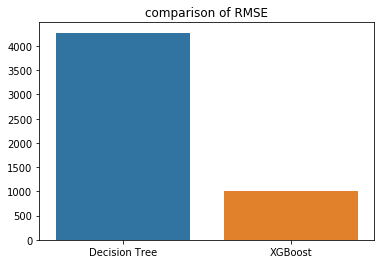

In [16]:
"""evaluate estimators"""
from sklearn.metrics import mean_squared_error
from math import sqrt

Y_PRED_list= [estimator_list[0].predict(test_X.drop(columns=drop_columns)),estimator_list[1].predict(test_X.drop(columns=drop_columns))]
rmse_list = [sqrt(mean_squared_error(test_Y, Y_PRED_list[0])),sqrt(mean_squared_error(test_Y, Y_PRED_list[1]))]
from sklearn.metrics import r2_score
r2_score_list = [(r2_score(test_Y, Y_PRED_list[0])),(r2_score(test_Y, Y_PRED_list[1]))]
print('R squared values:Decision Tree, XGBoost')
r2_score_list 
import seaborn as sns
sns.barplot(x=['Decision Tree','XGBoost'],y=rmse_list)
plt.title('comparison of RMSE')
rmse_list


#### Observation`: 
The models obtained above have the following rmse values on the test set:
1. Decision tree(Benchmark model): 4275
2. XGBoost model: 997

#### Inference
XGBoost model outperforms the Benchmark Decision tree model by a huge margin again. 
Model performance has improved significantly after tuning

## 11. Feature Selection


### 11.a. Method 1: Extracting important features using Genetic Algorithm
Genetic algorithm has been used as a feature selection technique in conjugation with XGBoost estimator. It searches for the best possible subset of features in a search space of 2^number_of_features so as to maximize performance.

Genetic Algorithm has been implemented in a custom function named *GeneticAlgorithm()* in the local_functions.py file

In [24]:
selected_features=pd.Series(dtype='object')
importlib.reload(local_functions)
#estimator_list[model_dict['XGBoost']], selected_features['XGBoost']= local_functions.GeneticAlgorithm(estimator_list[1],  X.drop(columns=drop_columns), Y.amount, n_generations= 50)

#Note:
# We have commented the code once the model has been trained and stored in an object. 
#We do not retrain it everytime due to computational complexity of genetic algorithm

#storing trained models and metrics for reproducing later as required
#joblib.dump(estimator_list, "model_objects/GA_estimator_list")
#joblib.dump(selected_features, "model_objects/selected_features")

estimator_list_ga= joblib.load("model_objects/GA_estimator_list")
selected_features= joblib.load("model_objects/selected_features")


### Printing selected features in genetic algorithm (XGBoost as estimator)

In [18]:
print("\nSelected Features using Genetic Algorithm-XGBoost")
print(pd.Series(selected_features['XGBoost'].tolist()))


Selected Features using Genetic Algorithm-XGBoost
0               medical_history_1
1               medical_history_2
2              preop_medication_6
3                       symptom_2
4                       symptom_5
5                age_at_admission
6        count_of_medical_history
7                   gender_Female
8                    race_Chinese
9                      race_Malay
10      resident_status_Foreigner
11    resident_status_Singaporean
12                bmi_band_normal
13                 bmi_band_obese
dtype: object


### 11.b. Method 2: Using classification learner method
Here we leverage the tree based algorithm to extract important features. *Gain* has been used as the featue importance criteria

*The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction*

#### 10 most important features (as per XGBoost algorithm)

Text(0.5, 1.0, 'Top 10 features')

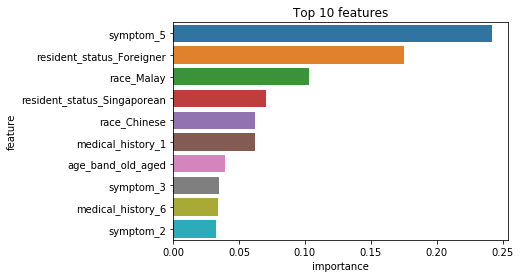

In [22]:
from my_utilities import my_decision_tree
importlib.reload(my_decision_tree)
importance_data= my_decision_tree.feature_importance(estimator_list[1],X.drop(columns=drop_columns))

sns.barplot(data= importance_data[0:10], x= 'importance', y='feature')
plt.title("Top 10 features")

## 12 Model Intuition 
A decision tree can be leveraged to understand the decision making pattern of the algorithm
### Plot of Decision tree

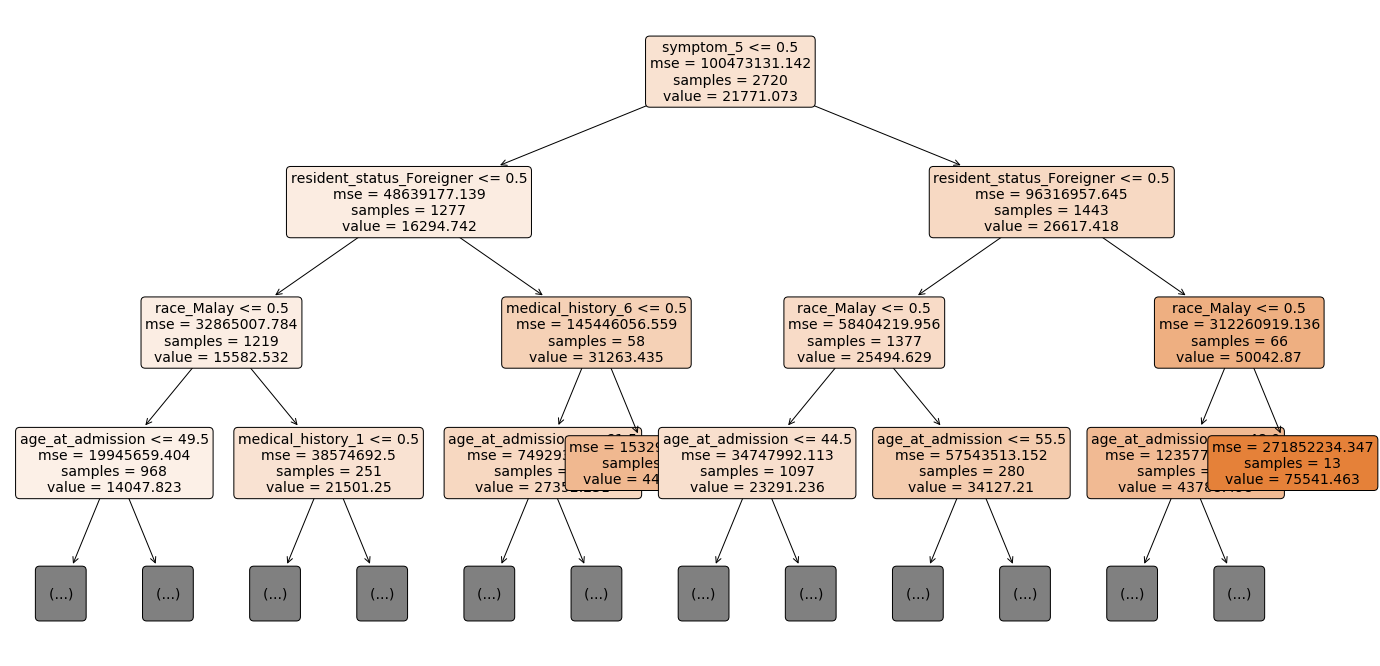

In [23]:
from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(24, 12))
tree.plot_tree(estimator_list[0], max_depth=3, feature_names=X.drop(columns=drop_columns).columns.values, class_names=True, proportion=False,
                              filled=True, fontsize=14, rounded= True)
plt.show()

#### Inference:
1. The above tree gives some intuition on how the decision is being taken by the algorithm 
2. Features on the top have maximum information content
3. Presence of symptom 5 corresponds to higher value of treatment: 26617 on average as compared to 16294 with its absence
4. Being a foreign resident further adds up to the cost
5. Further having race as Malay and old age at admission furhter adds up to the cost
6. Tree can be interpreted further to develop thumb rules of estimation

## Final words:
- We have been able to develop a model to predict cost of treatment given patient details.

- A point that needs to be highlighted again is that the prediction is total cost for each patient for a single date of admission. In case, the patient has multiple admissions to hospital, then his total cost can be obtained by adding costs predicted for his individual admissions.

- We have obtained high performance in the model obtaining a rmse of 997 on an independent test set. However, the performance is not final can can be improved further with more intense search of model hyperparameters and trying different learning algorithms like ANN
